In [ ]:
!pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
from time import time
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
ROOT = "/content/drive/MyDrive/dl-project"


SEED = 78

time_spent = {}
horizon = 187
input_size = 187

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv(f"{ROOT}/data/train_data_scaled.csv")
test = pd.read_csv(f"{ROOT}/data/test_data_scaled.csv")

In [ ]:
# Exigência do nixtla
train['unique_id'] = 'slug_flow'
train['ds'] = train['time']
train['y'] = train['liquid_flow_rate']


test['unique_id'] = 'slug_flow'
test['ds'] = test['time']
test['y'] = test['liquid_flow_rate']

### Training

In [ ]:
# https://nixtlaverse.nixtla.io/neuralforecast/models.lstm.html
models = [
    LSTM(
        h=horizon,
        input_size=input_size,
        encoder_hidden_size=10,
        encoder_n_layers=3,
        max_steps=500,
        val_check_steps=50,
        early_stop_patience_steps=5,
        random_seed=SEED
    )
]

INFO:lightning_fabric.utilities.seed:Seed set to 78


In [ ]:
start_time = time()
nf = NeuralForecast(
    models=models,
    freq=1
)

nf.fit(df=train, val_size=horizon)
time_spent['training_time'] = time() - start_time

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 2.3 K  | train
4 | mlp_decoder  | MLP           | 1.5 K  | train
-------------------------------------------------------
3.8 K     Trainable params
0         Non-trainable params
3.8 K     Total params
0.015     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print("Tempo de treinemento:", time_spent["training_time"], "seconds")

Tempo de treinemento: 114.55221772193909 seconds


### Predictions

In [ ]:
# Junta os últimos 'input_size' pontos do treino com os dados de teste
predictions_input_df = pd.concat([train.tail(input_size), test])

In [ ]:
# Cria janelas deslizantes do DataFrame para fazer predições
inputs_for_predicions_list = [
    predictions_input_df.iloc[i:i + input_size]
    for i in range(0, len(predictions_input_df) - input_size + 1, horizon)
]

In [ ]:
start_time = time()

forecasts_list = []
for input_df in inputs_for_predicions_list:
    forecast = nf.predict(df=input_df)
    forecasts_list.append(forecast)

time_spent['inference_time'] = time() - start_time

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print("Tempo de inferência:", time_spent["inference_time"], "seconds")

Tempo de inferência: 2.2518320083618164 seconds


In [ ]:
forecasts_output = pd.concat(forecasts_list)

In [ ]:
forecasts_output

,unique_id,ds,LSTM
0,slug_flow,1501,0.288876
1,slug_flow,1502,0.286371
2,slug_flow,1503,0.289340
3,slug_flow,1504,0.302271
4,slug_flow,1505,0.325394
...,...,...,...
182,slug_flow,3179,0.277680
183,slug_flow,3180,0.277677
184,slug_flow,3181,0.277686
185,slug_flow,3182,0.277705


In [ ]:
forecasts_output

,unique_id,ds,LSTM
0,slug_flow,1501,0.288876
1,slug_flow,1502,0.286371
2,slug_flow,1503,0.289340
3,slug_flow,1504,0.302271
4,slug_flow,1505,0.325394
...,...,...,...
182,slug_flow,3179,0.277680
183,slug_flow,3180,0.277677
184,slug_flow,3181,0.277686
185,slug_flow,3182,0.277705


In [ ]:
ground_truth = test[['unique_id', 'ds', 'y']]
ground_truth

,unique_id,ds,y
0,slug_flow,1501,0.459397
1,slug_flow,1502,0.471283
2,slug_flow,1503,0.484231
3,slug_flow,1504,0.496564
4,slug_flow,1505,0.510421
...,...,...,...
1495,slug_flow,2996,0.279759
1496,slug_flow,2997,0.279714
1497,slug_flow,2998,0.279125
1498,slug_flow,2999,0.278436


In [ ]:
lstm_results = pd.merge(
    ground_truth,
    forecasts_output,
    on=['unique_id', 'ds'],
    how='left'
)
lstm_results

,unique_id,ds,y,LSTM
0,slug_flow,1501,0.459397,0.288876
1,slug_flow,1502,0.471283,0.286371
2,slug_flow,1503,0.484231,0.289340
3,slug_flow,1504,0.496564,0.302271
4,slug_flow,1505,0.510421,0.325394
...,...,...,...,...
1495,slug_flow,2996,0.279759,0.278474
1496,slug_flow,2997,0.279714,0.305521
1497,slug_flow,2998,0.279125,0.290783
1498,slug_flow,2999,0.278436,0.282204


In [ ]:
lstm_results.to_csv(f"{ROOT}/results/lstm_results.csv", index=False)

### Performance Evaluation

In [ ]:
y_true = lstm_results['y']
y_pred = lstm_results['LSTM']

In [ ]:
print(f"MAE: {mean_absolute_error(y_true, y_pred)}")

MAE: 0.0279414799229424


In [ ]:
print(f"MSE: {mean_squared_error(y_true, y_pred)}")

MSE: 0.006841568456052638


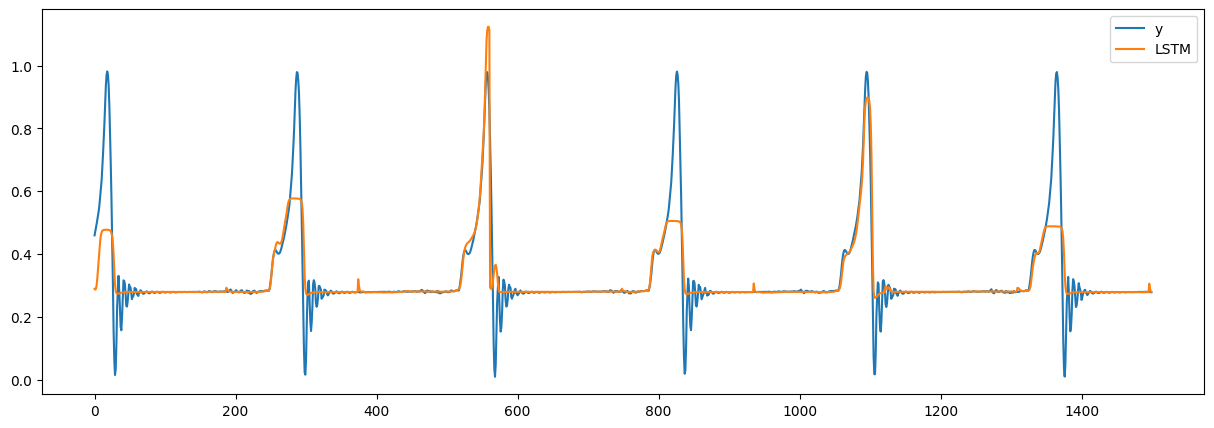

In [ ]:
lstm_results[['y', 'LSTM']].plot(figsize=(15, 5));

In [ ]:
# Salvar modelo
nf.save(path=f"{ROOT}/models/01-univariate/LSTM/")

In [ ]:
nf.save(path=f"{ROOT}/results/01-univariate/lstm_results.csv")